<a href="https://colab.research.google.com/github/Pathooo/Python-Data-Analysis/blob/main/solarpower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from sklearn.metrics import r2_score
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,RepeatedStratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer 
from scipy.special import boxcox1p

sns.set_color_codes(palette='bright')
R=69

sns.set_style("darkgrid")

In [ ]:
df = pd.read_csv('solarpowergeneration.csv')
df.head(10)

temperature_2_m_above_gnd  ...  generated_power_kw
0                       2.17  ...          454.100950
1                       2.31  ...         1411.999400
2                       3.65  ...         2214.849300
3                       5.82  ...         2527.609200
4                       7.73  ...         2640.203400
5                       8.69  ...         2546.081600
6                       9.72  ...         2270.320700
7                      10.07  ...         1063.830200
8                       9.38  ...           86.817611
9                       6.54  ...            9.666667

[10 rows x 21 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4213 entries, 0 to 4212
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temperature_2_m_above_gnd          4213 non-null   float64
 1   relative_humidity_2_m_above_gnd    4213 non-null   int64  
 2   mean_sea_level_pressure_MSL        4213 non-null   float64
 3   total_precipitation_sfc            4213 non-null   float64
 4   snowfall_amount_sfc                4213 non-null   float64
 5   total_cloud_cover_sfc              4213 non-null   float64
 6   high_cloud_cover_high_cld_lay      4213 non-null   int64  
 7   medium_cloud_cover_mid_cld_lay     4213 non-null   int64  
 8   low_cloud_cover_low_cld_lay        4213 non-null   int64  
 9   shortwave_radiation_backwards_sfc  4213 non-null   float64
 10  wind_speed_10_m_above_gnd          4213 non-null   float64
 11  wind_direction_10_m_above_gnd      4213 non-null   float

In [ ]:
#Renaming Cols for easier access and interpretation
df.columns=['temp','rel_humid','sealvl_pressure','total_rain','snow',
            'cloudcover','high_cloudcover','med_cloudcover','low_cloudcover','radiation','wspeed_10',
            'wdirection_10','wspeed_80','wdirection_80','wspeed_900','wdirection_900','wgust_10','aoi','zenith','azimuth','power']
df.describe()

temp    rel_humid  ...      azimuth        power
count  4213.000000  4213.000000  ...  4213.000000  4213.000000
mean     15.068111    51.361025  ...   169.167651  1134.347313
std       8.853677    23.525864  ...    64.568385   937.957247
min      -5.350000     7.000000  ...    54.379093     0.000595
25%       8.390000    32.000000  ...   114.136600   231.700450
50%      14.750000    48.000000  ...   163.241650   971.642650
75%      21.290000    70.000000  ...   225.085620  2020.966700
max      34.900000   100.000000  ...   289.045180  3056.794100

[8 rows x 21 columns]

In [ ]:
train,test=train_test_split(df,test_size=0.3,random_state=R)
data=[train,test]

In [ ]:
train.head(5)

temp  rel_humid  sealvl_pressure  ...     zenith     azimuth       power
1730  28.45         21           1018.2  ...  24.209078  225.170110  1431.58670
945   17.21         34           1011.4  ...  54.721943  243.309150  1475.60980
2920  19.84         84           1014.9  ...  70.792141   95.034868   643.89694
2040  24.45         34           1016.7  ...  65.656577  280.748400   147.31476
2011  27.65         23           1013.2  ...  54.452132  271.708960   303.14472

[5 rows x 21 columns]

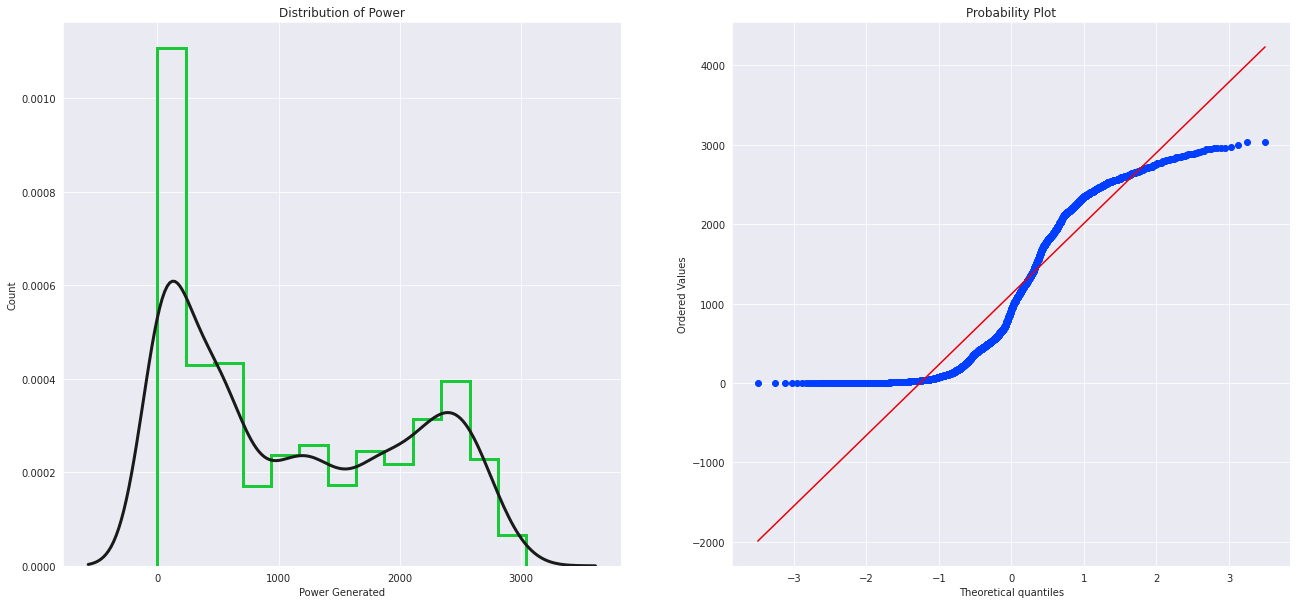

In [ ]:
fig,(ax,ax1)=plt.subplots(1,2,figsize=(22,10))
sns.distplot(train['power'],kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"},ax=ax)
ax.set(xlabel='Power Generated')
ax.set(ylabel='Count')
ax.set(title='Distribution of Power')

stats.probplot(train['power'], plot=ax1)
plt.show()

In [ ]:
print(f'Skewness: %f' %train['power'].skew())
print(f'Kurtosis: %f' %train['power'].kurt())

Skewness: 0.345575
Kurtosis: -1.358712


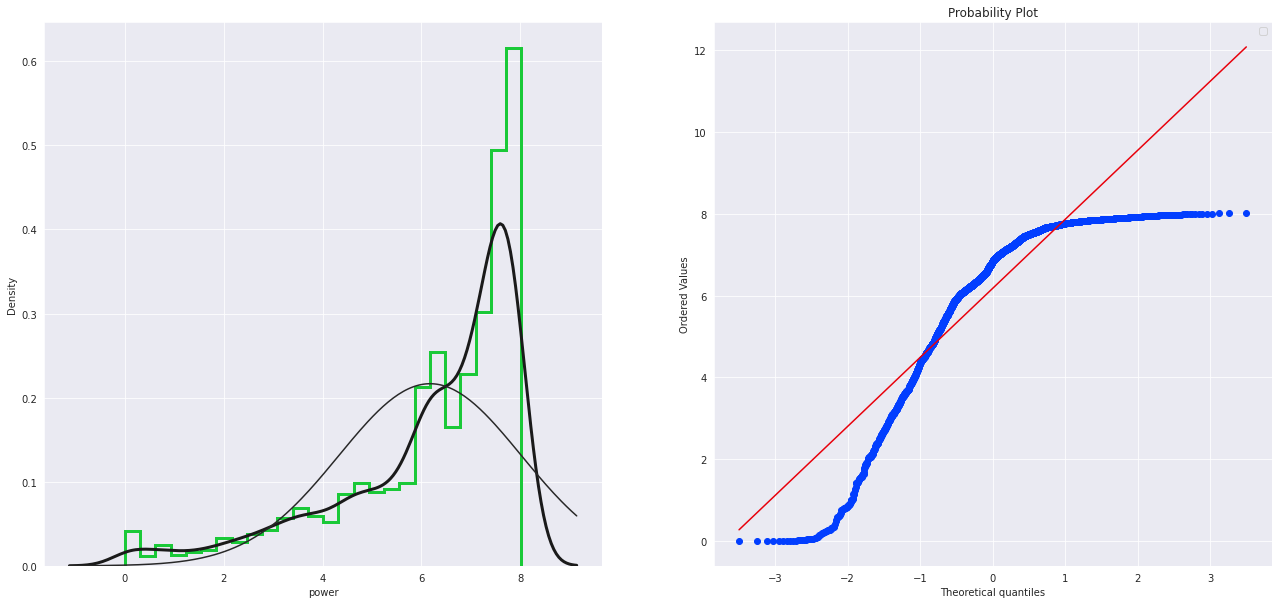

In [ ]:
train['power']=np.log1p(train['power'])


fig,(ax,ax1)=plt.subplots(1,2,figsize=(22,10))
sns.distplot(train['power'],kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"},ax=ax,fit=norm)

(mu, sigma) = norm.fit(train['power'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Count')
plt.title('Power distribution')

stats.probplot(train['power'], plot=ax1)
plt.show()


In [ ]:
train['power']=np.expm1(train['power'])

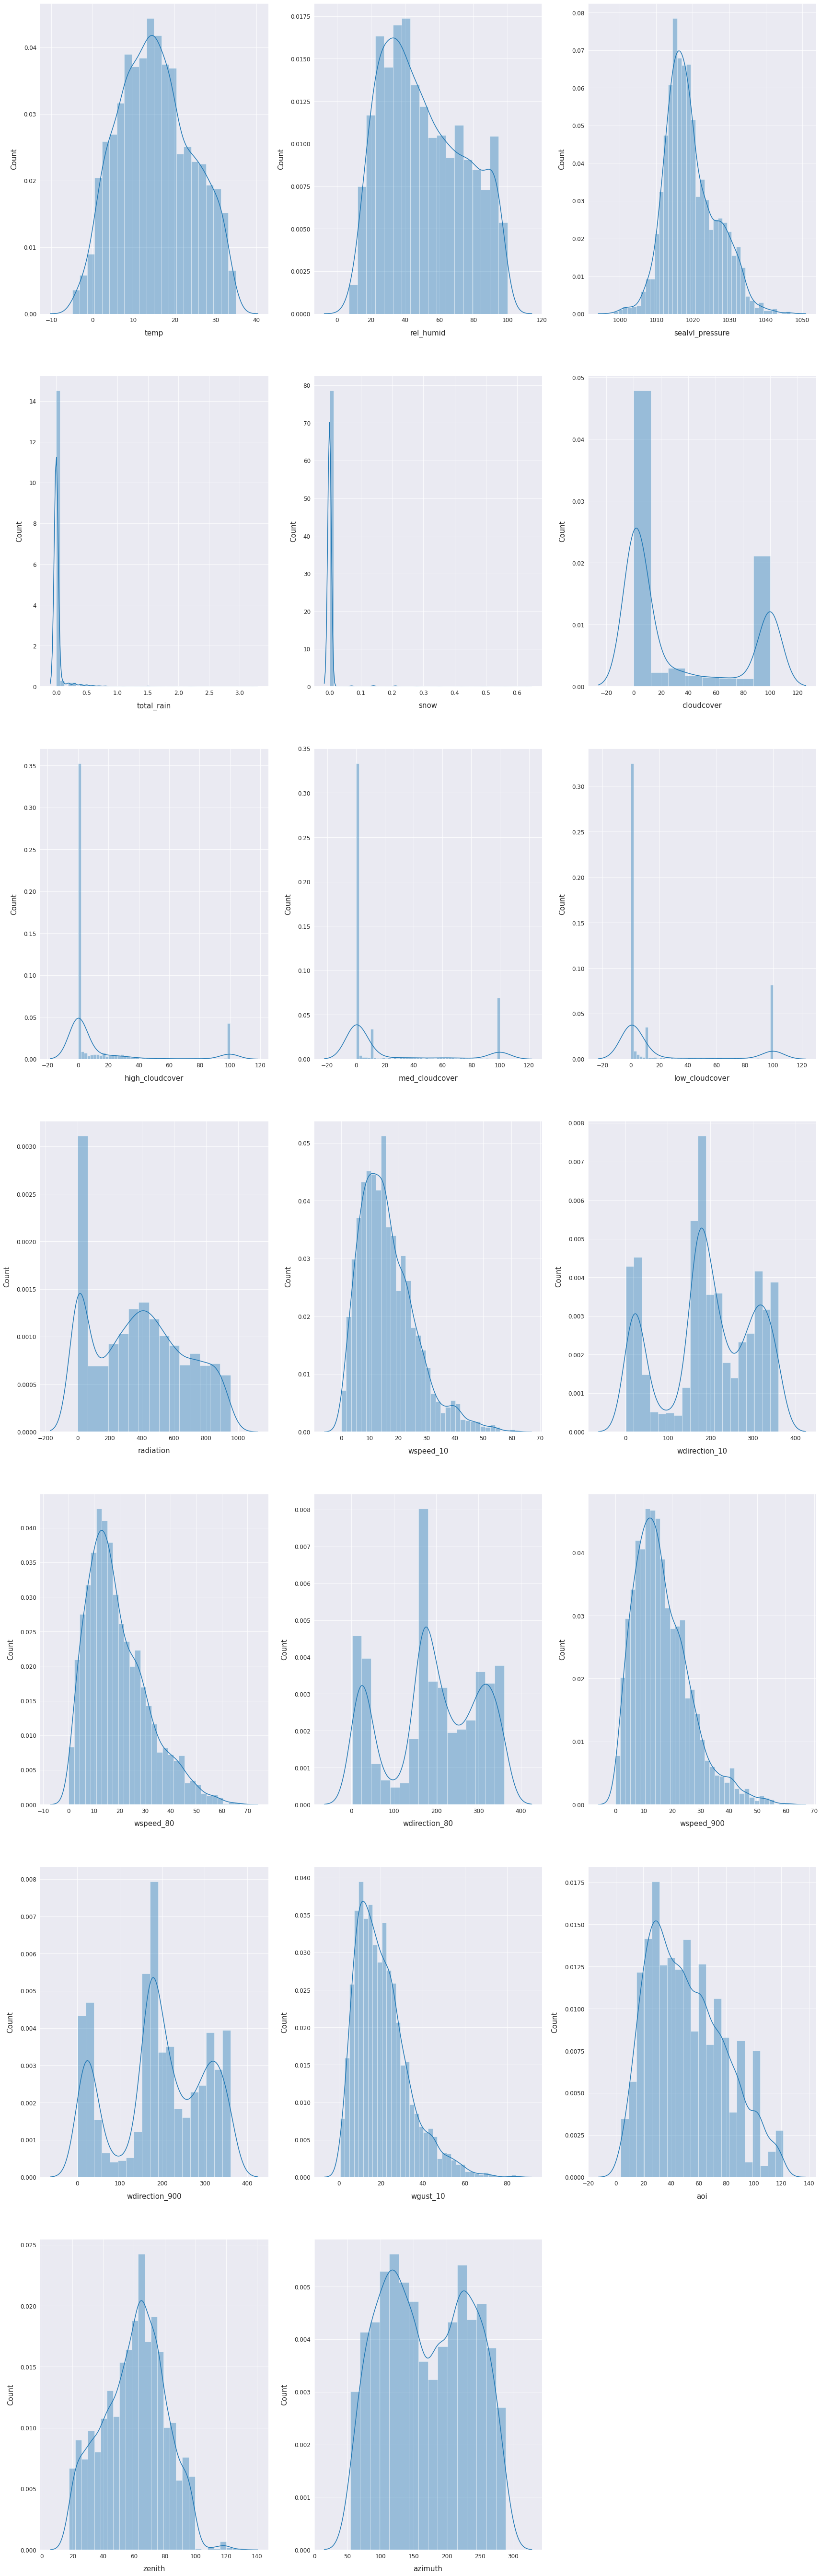

In [ ]:
sns.color_palette("husl", 8)
d,ax=plt.subplots(figsize=(12,120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i,feature in enumerate(list(train.columns),1):
  if feature == 'power':
    break
  plt.subplot(len(list(train.columns)),3,i)
  sns.distplot(train[feature])
  plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
  plt.ylabel('Count', size=15, labelpad=12.5)
  plt.tick_params(axis='x', labelsize=12)
  plt.tick_params(axis='y', labelsize=12)
    
plt.show()
  

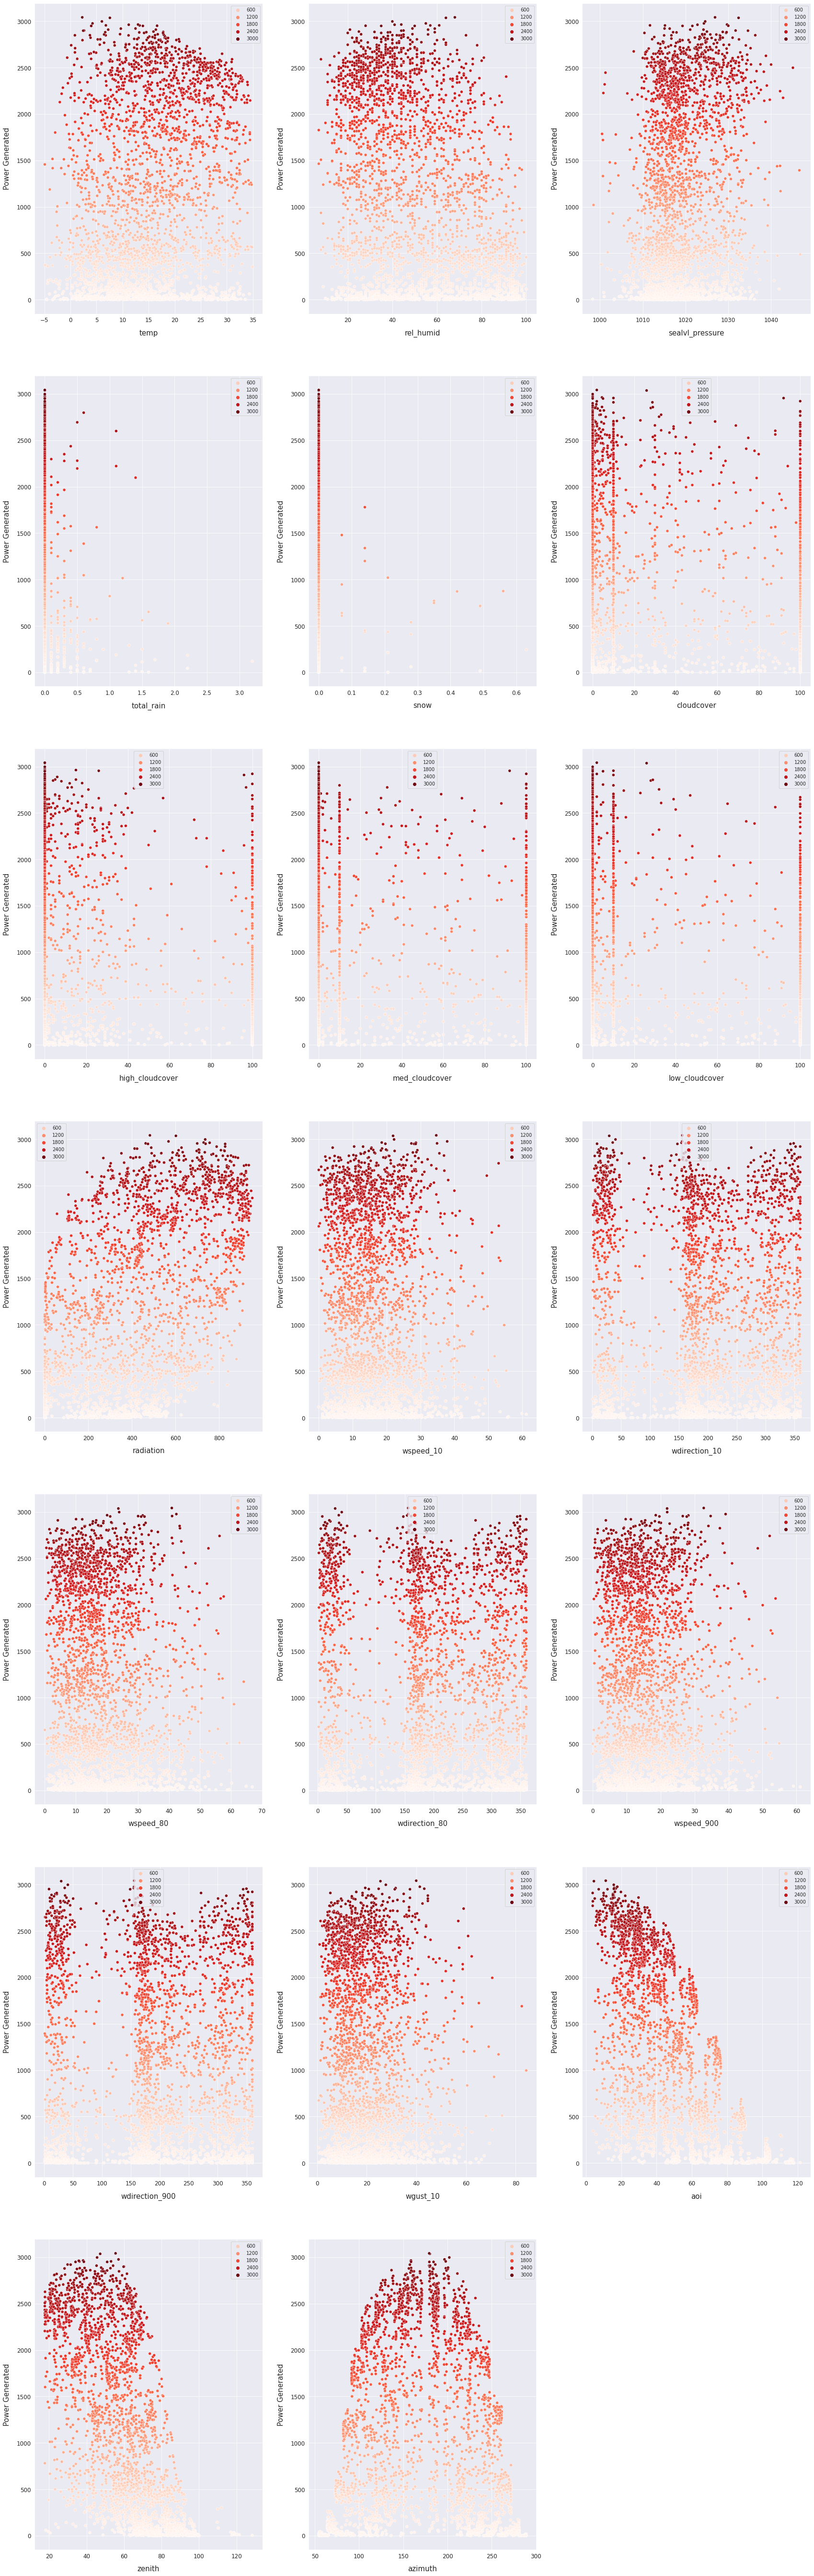

In [ ]:
sns.color_palette("husl", 8)
d,ax=plt.subplots(figsize=(12,120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i,feature in enumerate(list(train.columns),1):
  if feature == 'power':
    break
  plt.subplot(len(list(train.columns)),3,i)
  sns.scatterplot(x=feature,y='power',data=train,palette='Reds',hue='power')
  plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
  plt.ylabel('Power Generated', size=15, labelpad=12.5)
  plt.tick_params(axis='x', labelsize=12)
  plt.tick_params(axis='y', labelsize=12)
    
  plt.legend(loc='best', prop={'size': 10})
plt.show()
  

In [ ]:

df['has_rain']=0
df.loc[df['total_rain']>0,'has_rain']=1

df['has_snow']=0
df.loc[df['snow']>0,'has_snow']=1

df['zen_azi_ratio']=df['zenith'] / df['azimuth']

df['temp_humid_ratio']=df['temp'] / df['rel_humid']
  

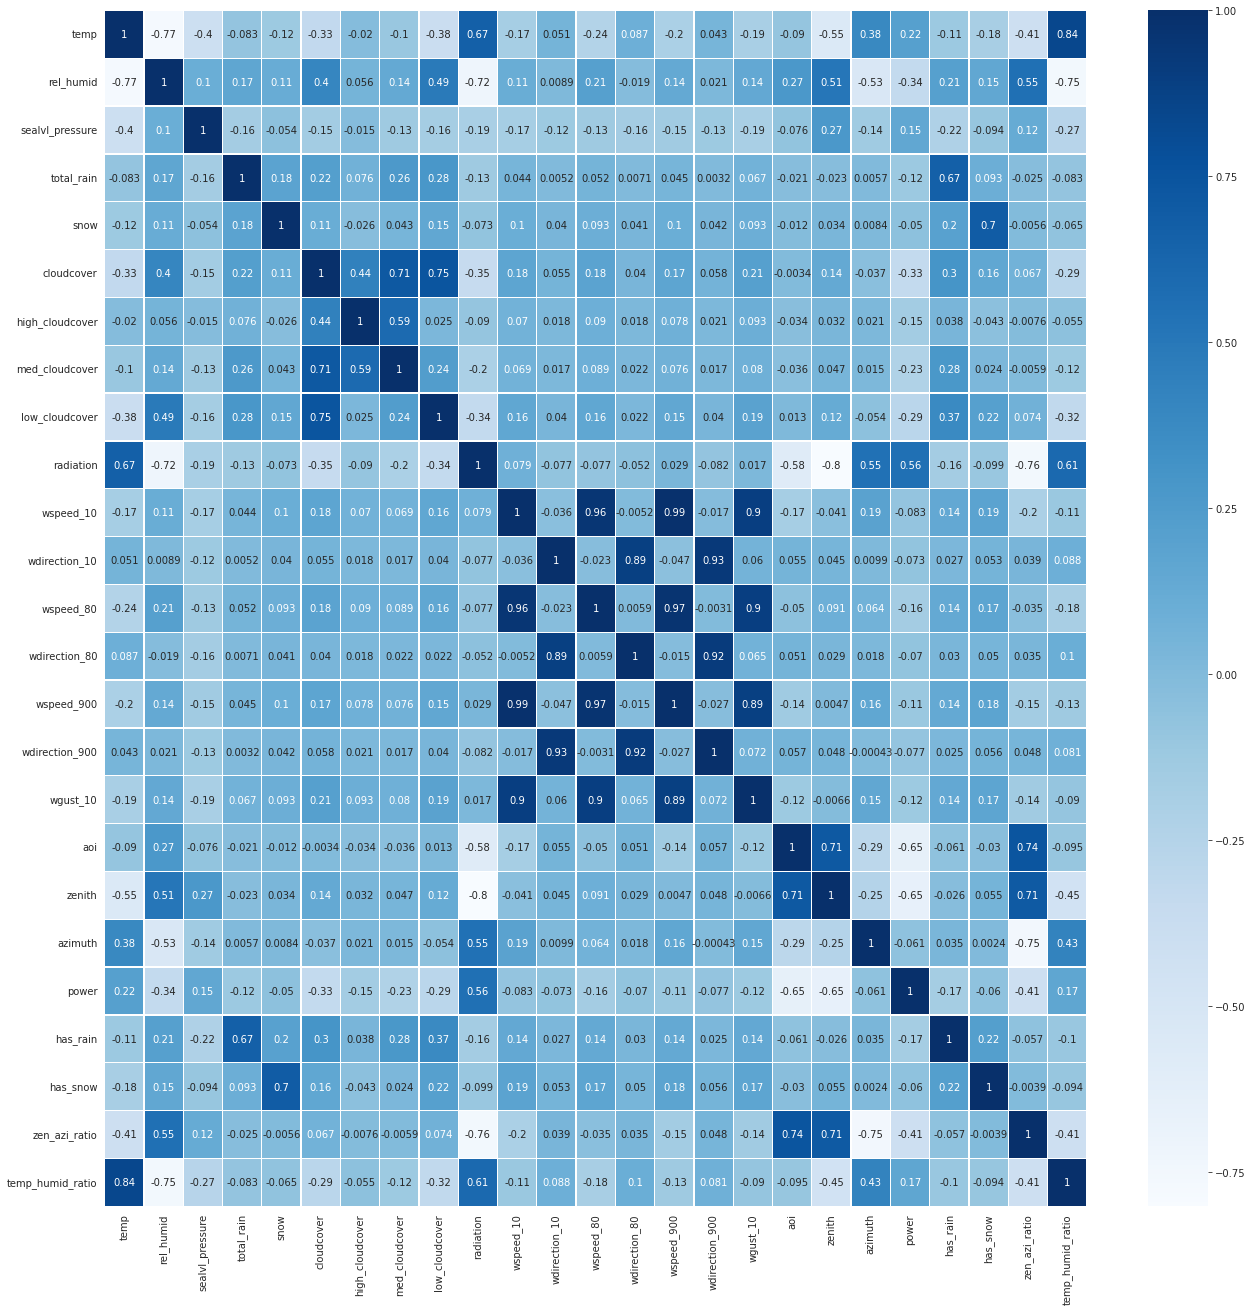

In [ ]:
corrmatrix=df.corr()
f, ax=plt.subplots(figsize=(22,22))
sns.heatmap(corrmatrix,annot=True,cmap='Blues',linewidths=0.3)
plt.show()

In [ ]:
skew_features= df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_features=pd.DataFrame({'skew':skew_features})
skew_features.head(10)

skew
snow              26.268942
has_snow           9.308576
total_rain         8.627263
has_rain           3.286598
temp_humid_ratio   2.318355
high_cloudcover    2.142525
zen_azi_ratio      1.695171
med_cloudcover     1.537427
low_cloudcover     1.448766
wgust_10           1.110831

In [ ]:
skew_features=skew_features[abs(skew_features)>0.75]
skew_features.shape


skewed_features = skew_features.index
lam = 0.15
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], lam)

In [ ]:
train,test=train_test_split(df,test_size=0.3,random_state=R)

MOdelling

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# X=df.drop(['power'],axis=1,inplace=True)
# Y=df['power']

In [ ]:
# X_train=X[]
# X_test=
# Y_train=
# Y_test=

In [ ]:
n_folds = 5

y_train = train.power.values


def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=R)
    rmse= np.sqrt(-cross_val_score(model, train.drop(['power'],axis=1).values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
linear= make_pipeline(StandardScaler(),LinearRegression())

Lasso

In [ ]:
lasso= make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=R))

Elastic NEt

In [ ]:
enet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=0.4,random_state=R))

In [ ]:
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2)

GBM

In [ ]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =R)

Random FOrest

In [ ]:
rforest=RandomForestRegressor(n_estimators=3000,max_depth=4, min_samples_leaf=20, random_state=R)


Light Gradient Boosting

In [ ]:
lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

XG Boosting

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
score=rmsle_cv(krr)
print('Linear Regression -->  {:.4f}'.format(np.mean(score)))

Linear Regression -->  465.9570
